# EDS 296 Final Project: Climate Projection Over the Hawaiian Islands
### Madison Enda, Bailey Jorgensen, Michelle Yiv 
### 06/10/2025

#### Link to repository on Github: https://github.com/madisonenda/EDS296-Final-Project

## Introduction

We chose to analyze how climate change is projected to impact the Hawaiian Islands. In the past few decades, Hawaii has tried hard to curtail the ill effects of harmful algal blooms on its more populated islands, like Oahu and Maui. These HABS events, the result of increased water pollution and Hawaii's naturally warm climate, destroy the coral reefs that protect the islands from wave/storm damage and flooding.

With the looming threat of climate change, we wondered whether or not temperatures would increase dramatically enough in the equatorial region to incite more algal blooms or generally become too warm for reef building coral in the coming decades.

![Hawaii. Source: seatemperatu.re](https://www.seatemperatu.re/site/images/illustration/hawai_642.jpg) 

## Metrics Definition:

All of our data came from CMIP6 catalog currently hosted by Amazon. For our climate scenarios, we chose to use all the years available for our historic simulations, as well as all the data available for future projection ssp370. We chose a predicted emissions scenario between the higher possible projections (ssp585) and the lower possible projections (ssp126) for a conservative yet realistic estimate. In ssp370, we predict additional radiative force of about 7 W/m² by the year 2100.

For our models, we chose CESM2 and CanESM5, both models that we knew to have solid coverage of our region, and that had worked well in similar analysis in the past. For the final analysis, we used ACCESS-CM2, as the aforementioned models had a great deal more ensemble members, that were too computationally intensive to work with.

The variables we chose to look at were near-surface air temperature (tas), precipitation (pr), and near-surface shortwave radiation (rsds). We believed air temperature would be a good indication of overall temperature trends on both land and in the water, that precipitation would be indicative of runoff volume, and that radiation would tell us more about cloud cover and clue us in to specific trends between land and sea.

![Hawaii Map. Source: mauihawaii.org](https://www.mauihawaii.org/wp-content/uploads/2021/12/hawaii-map-feature.jpg) 

## Setup

In [52]:
# Set up
import xarray as xr
import matplotlib.pyplot as plt
import intake
import s3fs
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Point
import scipy.stats as stats

## Variable 1: Near-Surface Air Temperature (tas)

### Access the catalogue
- Models: CANESM5, CESM2
- Scenario: ssp370
- Variables: mrsol (used here), tos, pr
- Member ID: r10i1p1f1

In [5]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Search through catalog, find all historical simulations
res = catalog.search(activity_id="CMIP", experiment_id="historical")

# Convert to a data frame
res_df = res.df

# Find historical simulations from two models
res_can = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CanESM5")
res_ces = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CESM2")

# Convert these to dataframes
res_can_df = res_can.df
res_ces_df = res_ces.df

# Print all unique ensemble members ("member_id")
# members_can = res_can_df.member_id.unique()
# members_ces = res_ces_df.member_id.unique()

### Specify search terms to query catalog for CanESM5 and CESM2
- activity_id: which project do you want? CMIP = historical data
- source_id: models of interest
- experiment_id: what experimental configuration do you want? Here we want historical
- member_id: which ensemble member do you want? Here we want r10i1p1f1
- table_id: which part of the Earth system and time resolution do you want?
- datavariable_id: which climate variable? soil moisture

#### Variable of interest
- Surface temperature, TAS

In [6]:
# Specify search terms

# Specifiy timing
activityid_hist = ['CMIP']
activityid_fut = ['ScenarioMIP']

experimentid_hist = ['historical']
experimentid_fut = ['ssp370']

# Common search terms
memberid = ['r10i1p1f1']
tableid = ['Amon']
variableid = ['tas']

# CanESM5 
sourceid_can = ['CanESM5']

# CESM2
sourceid_ces = ['CESM2']

In [7]:
# Search through catalog & store results for both models 
# CANESM5
res_can_hist = catalog.search(
    activity_id= activityid_hist,
    source_id= sourceid_can,
    experiment_id= experimentid_hist,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

res_can_fut = catalog.search(
    activity_id= activityid_fut,
    source_id= sourceid_can,
    experiment_id= experimentid_fut,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

# Cesm2 
res_ces_hist = catalog.search(
    activity_id= activityid_hist,
    source_id= sourceid_ces,
    experiment_id= experimentid_hist,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

res_ces_fut = catalog.search(
    activity_id= activityid_fut,
    source_id= sourceid_ces,
    experiment_id= experimentid_fut,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

In [8]:
# Show both model results as a dataframe
display(res_can_hist.df)
display(res_can_fut.df)

display(res_ces_hist.df)
display(res_ces_fut.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


### Save historical and future projection data

In [9]:
# Save both models - historical and future data 

# CANESM5
hist_can = xr.open_zarr(res_can_hist.df['zstore'][0], storage_options={'anon': True})
fut_can = xr.open_zarr(res_can_fut.df['zstore'][0], storage_options={'anon': True})

# CESM2
hist_ces = xr.open_zarr(res_ces_hist.df['zstore'][0], storage_options={'anon': True})
fut_ces = xr.open_zarr(res_ces_fut.df['zstore'][0], storage_options={'anon': True})

In [10]:
# Concatenate historic and future data

# CANESM5
can_data = xr.concat([hist_can, fut_can], dim="time")

# CESM2
ces_data = xr.concat([hist_ces, fut_ces], dim="time")

## Defining our area of interest (Hawaii)

Once we define our bounding box to show both Hawaii and the area around it, we will follow these steps:

- 1. Define and apply a logical mask, meaning that we only want the points WITHIN our bounding box or location of interest
- 2. Then we define and apply a weight function. This accounts for grid cells that are near the poles and cover less surface area than those near the equator
- 3. We then take the mean over latitude and longitude. This gives us a time series, where each point represent the average surface temperature for our time point
- 4. Then to slice our data, we convert to standard calendar
- 5. We can slice our data to both historical and future time period selections for each model. 
      - Here, we look at historical (1850-2015) and our future projections (2015-2050)
- 6. Now we can calculate annual mean for TAS for both models and time periods

In [11]:
# Define bounds for Hawaii
lat_min, lat_max = 18.64, 22.5
lon_min, lon_max = -160.8, -154

#lat_min, lat_max = 10.4, 14.7
#lon_min, lon_max = 102.0, 107.6

# Convert coordinates system
# Convert coordinates system
can_data = can_data.assign_coords(lon=((can_data.lon + 180) % 360 - 180))
ces_data = ces_data.assign_coords(lon=((ces_data.lon + 180) % 360 - 180))

In [12]:
# 1. Define logical mask: True when lat/lon inside the valid ranges, False elsewhere

# CAN
can_lat = (can_data.lat >= lat_min) & (can_data.lat <= lat_max)
can_lon = (can_data.lon >= lon_min) & (can_data.lon <= lon_max)


# CES
ces_lat = (ces_data.lat >= lat_min) & (ces_data.lat <= lat_max)
ces_lon = (ces_data.lon >= lon_min) & (ces_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points

# CAN
can_mask = can_data.where(can_lat & can_lon, drop=True)

# CES
ces_mask = ces_data.where(ces_lat & ces_lon, drop=True)

In [13]:
# 2. Define function to generate area weights
def weights(dat):
    # Calculate weighting factor = cosine of latitude
    coslat = np.cos(np.deg2rad(dat.lat))
    weight_factor = coslat / coslat.mean(dim='lat')
    
    # Weight all points by the weighting factor
    computed_weight = dat * weight_factor
    
    # Return the set of weights: this has dimension equal to that of the input data
    return computed_weight

In [14]:
# Apply weights function to our models

# CAN
weight_can = weights(can_mask)

# CES
weight_ces = weights(ces_mask)

In [15]:
# 3. Get mean for time series
can_avg = weight_can.mean(dim=["lat", "lon"])
ces_avg = weight_ces.mean(dim=["lat", "lon"])

In [16]:
 # 4. Convert to standard calendar
can_avg = can_avg.convert_calendar('standard', use_cftime=False)
ces_avg = ces_avg.convert_calendar('standard', use_cftime=False)

In [17]:
# 5. Select historical and future times

# CAN
can_hist = can_avg.sel(
    time=slice('1850-01-01', '2015-12-31'))
    
can_fut = can_avg.sel(
    time=slice('2016-01-01', '2050-12-31'))
 
# CES
ces_hist = ces_avg.sel(
    time=slice('1850-01-01', '2015-12-31'))
    
ces_fut = ces_avg.sel(
    time=slice('2016-01-01', '2050-12-31'))

In [18]:
# 6. Calculate annual mean

can_hist_annual = can_hist.groupby('time.year').mean(dim='time')['tas']
can_fut_annual  = can_fut.groupby('time.year').mean(dim='time')['tas']

ces_hist_annual = ces_hist.groupby('time.year').mean(dim='time')['tas']
ces_fut_annual  = ces_fut.groupby('time.year').mean(dim='time')['tas']

### Plotting the results

In [19]:
# Calculate trend lines

# CAN historical trend line
x_can_hist = np.polyfit(can_hist_annual['year'].values, can_hist_annual.values, 1)
trend_can_hist = np.poly1d(x_can_hist)

# CAN future trend line
x_can_fut = np.polyfit(can_fut_annual['year'].values, can_fut_annual.values, 1)
trend_can_fut = np.poly1d(x_can_fut)

# CES historical trend line
x_ces_hist = np.polyfit(ces_hist_annual['year'].values, ces_hist_annual.values, 1)
trend_ces_hist = np.poly1d(x_ces_hist)

# CES future trend line
x_ces_fut = np.polyfit(ces_fut_annual['year'].values, ces_fut_annual.values, 1)
trend_ces_fut = np.poly1d(x_ces_fut)

#### CANESM5 Historical & Future

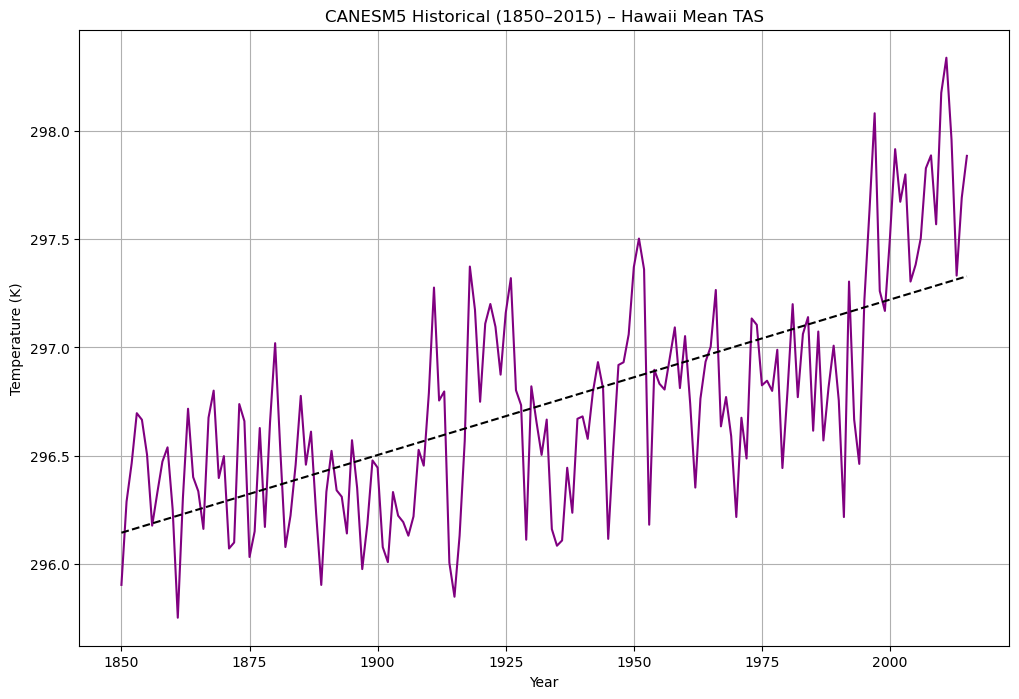

In [20]:
# Initialize plot
plt.figure(figsize=(12, 8))

# Plot time series
plt.plot(can_hist_annual['year'].values, can_hist_annual.values, color='purple')

# Plot trend line
plt.plot(can_hist_annual['year'].values, trend_can_hist(can_hist_annual['year'].values), 
         color='black', linestyle='--', label='Trend Line')

# Add labels
plt.title('CANESM5 Historical (1850–2015) – Hawaii Mean TAS')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')

plt.grid(True)
plt.show()

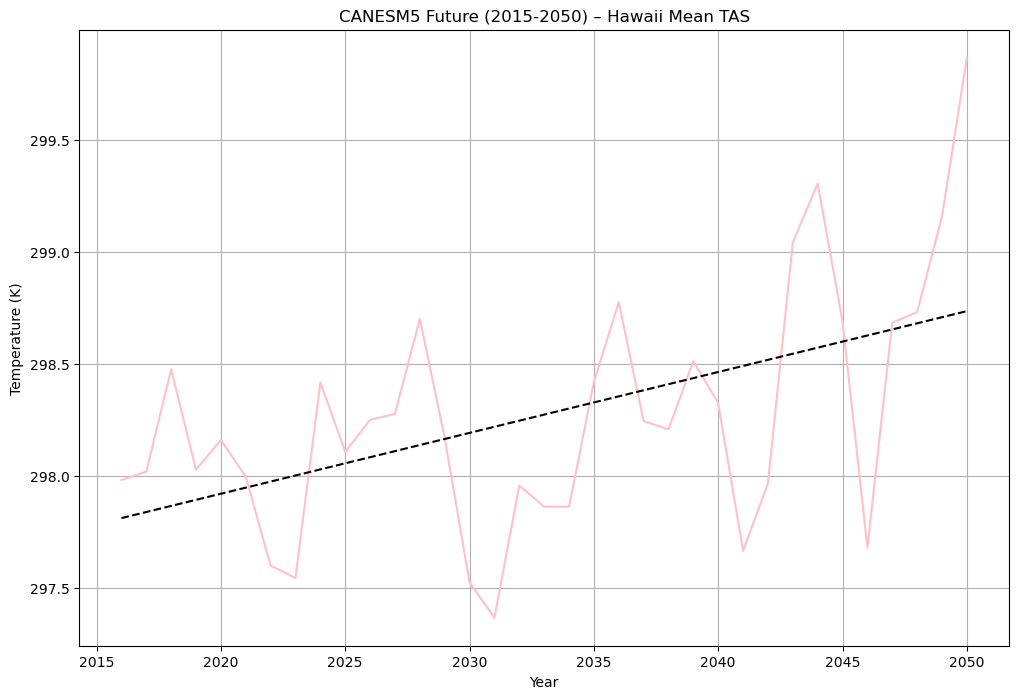

In [21]:
# Initialize plot
plt.figure(figsize=(12, 8))

# Plot time series
plt.plot(can_fut_annual['year'].values, can_fut_annual.values, color='pink')

# Plot trend line
plt.plot(can_fut_annual['year'].values, trend_can_fut(can_fut_annual['year'].values), 
         color='black', linestyle='--', label='Trend Line')

# Add labels
plt.title('CANESM5 Future (2015-2050) – Hawaii Mean TAS')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')

plt.grid(True)
plt.show()

The CanESM5 models show a steady historical increase in near surface air temperature, with a predicted increase to around 299.8 Kelvin, or 27 degrees Celsius, by the year 2050. This is about 1 degree warmer than the average annual temperature in this region. 

In previous assignments, we visualized this information for the highest emission scenario, ssp585, and found that the maximum expected increase in this region was about 2 degrees Celsius.

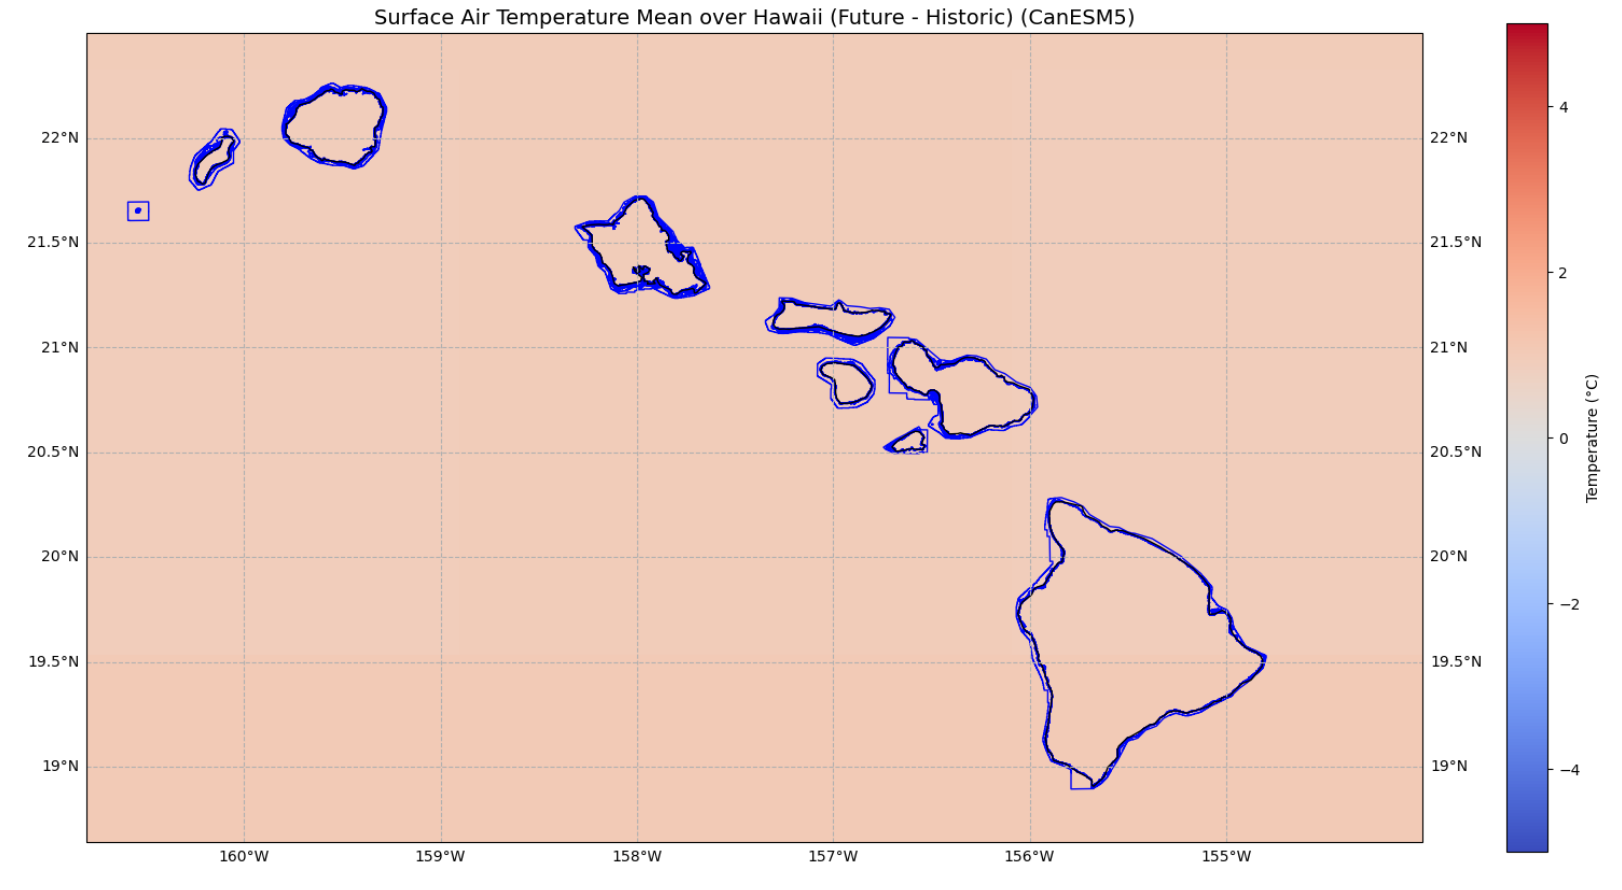

#### CESM2 Historical & Future

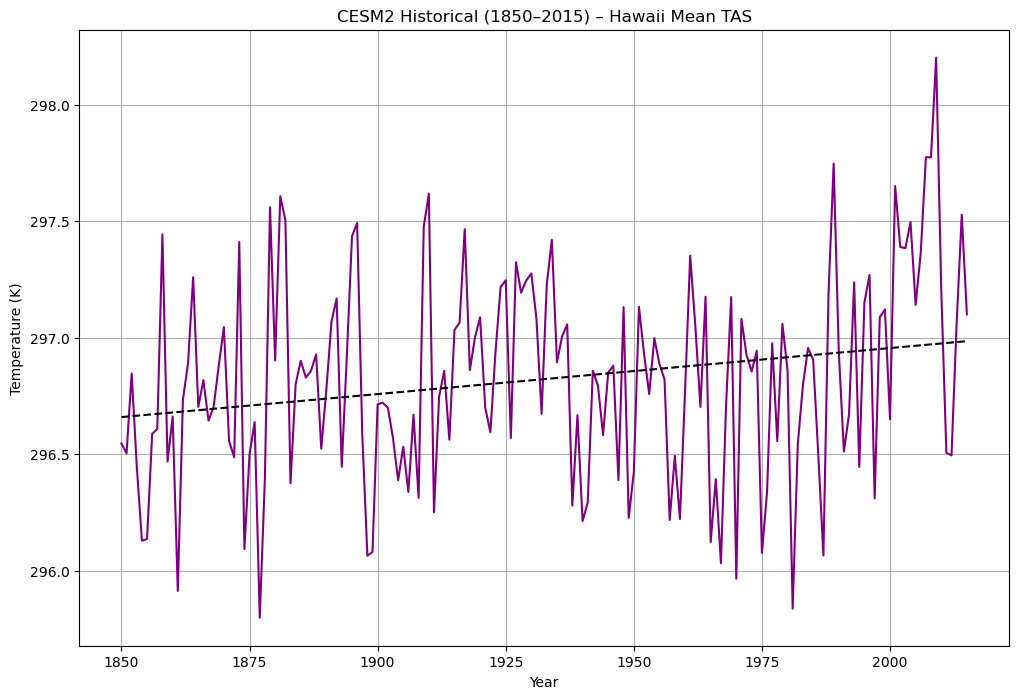

In [22]:
# Initialize plot
plt.figure(figsize=(12, 8))

# Plot time series
plt.plot(ces_hist_annual['year'].values, ces_hist_annual.values, color='purple')

# Plot trend line
plt.plot(ces_hist_annual['year'].values, trend_ces_hist(ces_hist_annual['year'].values), 
         color='black', linestyle='--', label='Trend Line')

# Add labels
plt.title('CESM2 Historical (1850–2015) – Hawaii Mean TAS')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')

plt.grid(True)
plt.show()

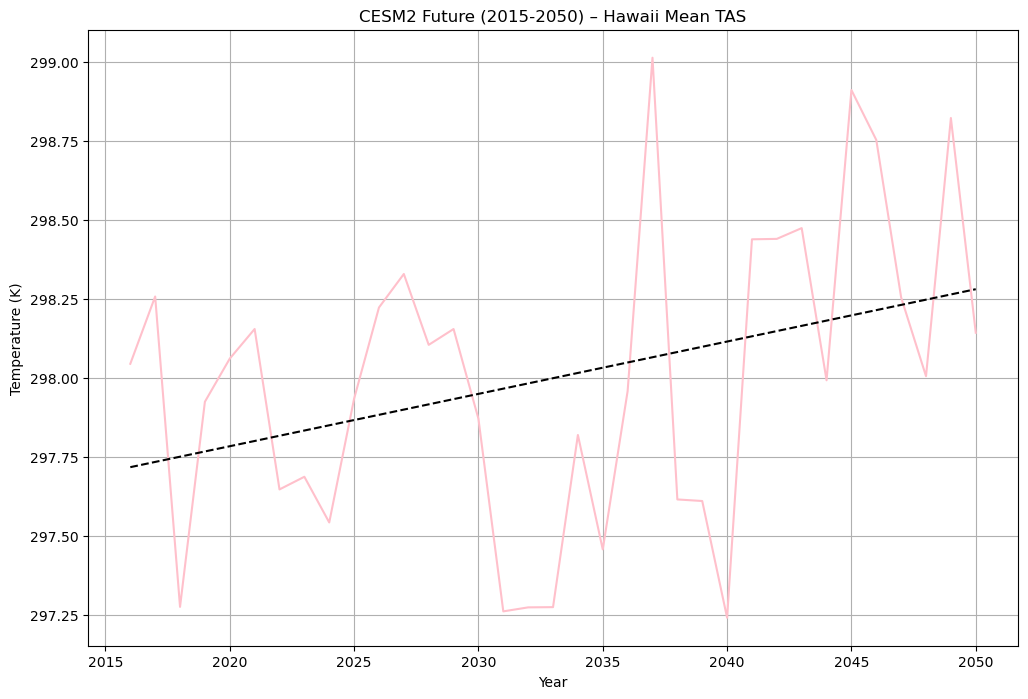

In [23]:
# Initialize plot
plt.figure(figsize=(12, 8))

# Plot time series
plt.plot(ces_fut_annual['year'].values, ces_fut_annual.values, color='pink')

# Plot trend line
plt.plot(ces_fut_annual['year'].values, trend_ces_fut(ces_fut_annual['year'].values), 
         color='black', linestyle='--', label='Trend Line')

# Add labels
plt.title('CESM2 Future (2015-2050) – Hawaii Mean TAS')
plt.xlabel('Year')
plt.ylabel('Temperature (K)')

plt.grid(True)
plt.show()

The CESM2 models similarly show a steady increase in both historical and future projections, but slightly lower than the CanESM5 predictions, at a maximum temperature of around 299 but at around 298.2, or 25.2 degrees Celsius, by the year 2050.

The map created in earlier work confirms this trend. We attribute the smaller variation in temperature change to Hawaii's position close to the equator.

Surface Air Temperature Mean over Hawaii (Future - Historic) (CESM2)
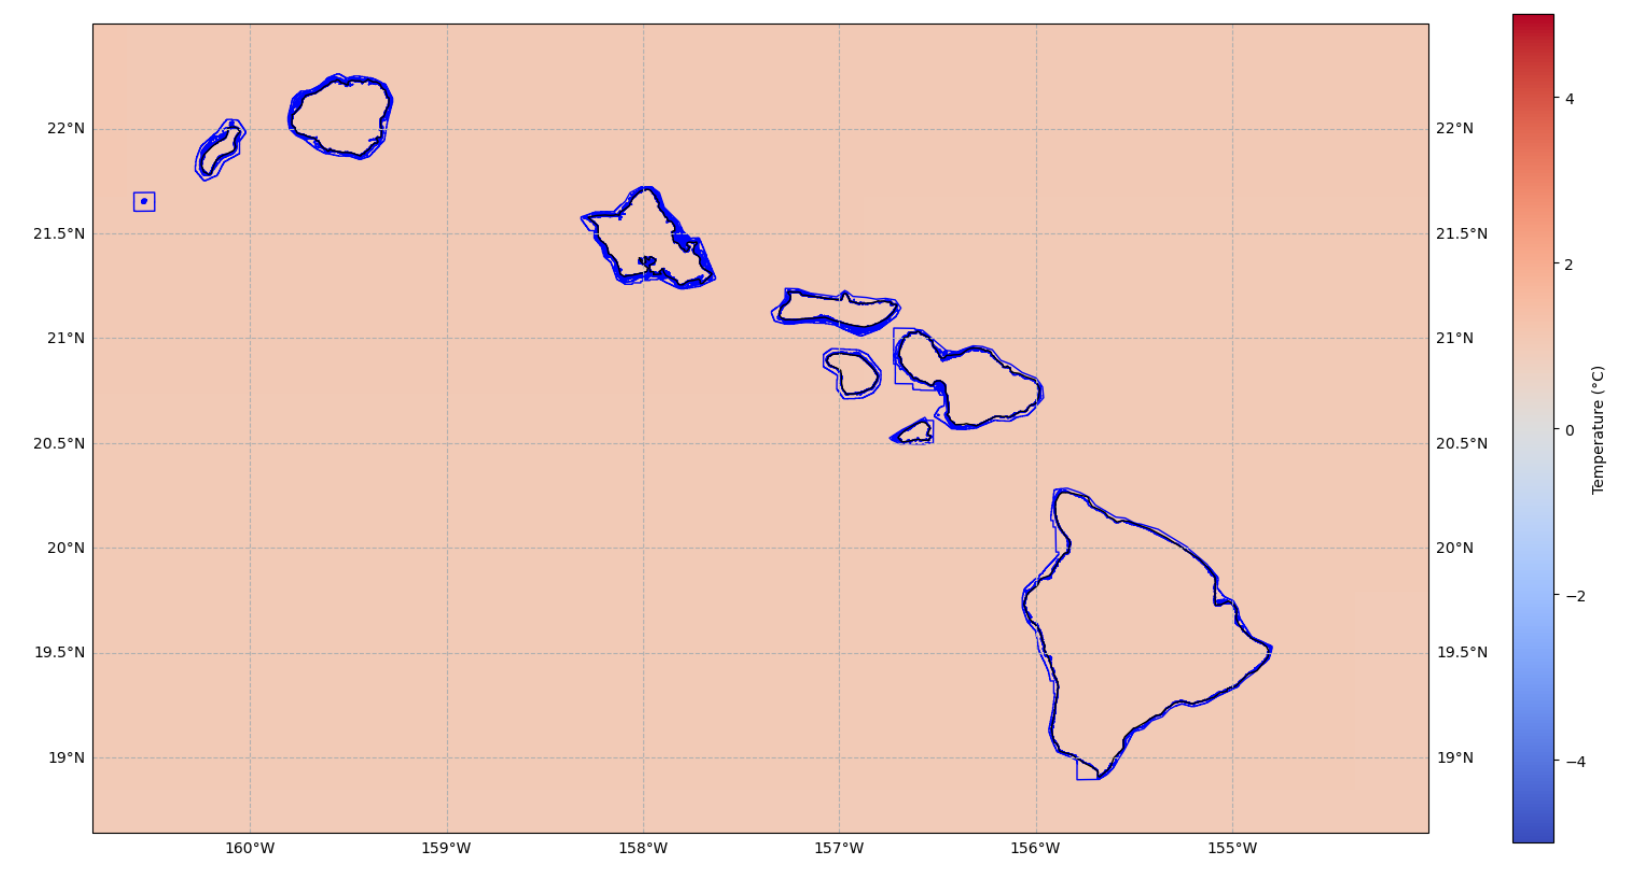

## Variable 2: Precipitation (pr)

In [27]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

# Search through catalog, find all historical simulations
res = catalog.search(activity_id="CMIP", experiment_id="historical")

# Convert to a data frame
res_df = res.df

# Find historical simulations from two models
res_can = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CanESM5")
res_ces = catalog.search(activity_id="CMIP", experiment_id="historical", source_id="CESM2")

# Convert these to dataframes
res_can_df = res_can.df
res_ces_df = res_ces.df

In [28]:
# Specify search terms

# Specifiy timing
activityid_hist = ['CMIP']
activityid_fut = ['ScenarioMIP']

experimentid_hist = ['historical']
experimentid_fut = ['ssp370']

# Common search terms
memberid = ['r10i1p1f1']
tableid = ['Amon']
variableid = ['pr']

# CanESM5 
sourceid_can = ['CanESM5']

# CESM2
sourceid_ces = ['CESM2']

In [29]:
# Search through catalog & store results for both models 

# CANESM5
res_can_hist = catalog.search(
    activity_id= activityid_hist,
    source_id= sourceid_can,
    experiment_id= experimentid_hist,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

res_can_fut = catalog.search(
    activity_id= activityid_fut,
    source_id= sourceid_can,
    experiment_id= experimentid_fut,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

# Cesm2 
res_ces_hist = catalog.search(
    activity_id= activityid_hist,
    source_id= sourceid_ces,
    experiment_id= experimentid_hist,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

res_ces_fut = catalog.search(
    activity_id= activityid_fut,
    source_id= sourceid_ces,
    experiment_id= experimentid_fut,
    member_id= memberid,
    table_id= tableid,
    variable_id= variableid)

In [30]:
# Show both model results as a dataframe
display(res_can_hist.df)
display(res_can_fut.df)

display(res_ces_hist.df)
display(res_ces_fut.df)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,CCCma,CanESM5,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20200124


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,ScenarioMIP,NCAR,CESM2,ssp370,r10i1p1f1,Amon,pr,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528


In [31]:
# CANESM5
hist_can = xr.open_zarr(res_can_hist.df['zstore'][0], storage_options={'anon': True})
fut_can = xr.open_zarr(res_can_fut.df['zstore'][0], storage_options={'anon': True})

# CESM2
hist_ces = xr.open_zarr(res_ces_hist.df['zstore'][0], storage_options={'anon': True})
fut_ces = xr.open_zarr(res_ces_fut.df['zstore'][0], storage_options={'anon': True})

In [32]:
# Concatenate historic and future data

# CANESM5
can_data = xr.concat([hist_can, fut_can], dim="time")

# CESM2
ces_data = xr.concat([hist_ces, fut_ces], dim="time")

In [33]:
# Define bounds for Hawaii
lat_min, lat_max = 18.64, 22.5
lon_min, lon_max = -160.8, -154

# Define the time periods 
hist = [1850, 2015]
fut = [2050, 2080]

# Convert to date time
can_data['time'] = can_data.time.astype('datetime64[ns]')
ces_data['time'] = ces_data.time.astype('datetime64[ns]')

# Convert coordinates system
can_data = can_data.assign_coords(lon=((can_data.lon + 180) % 360 - 180))
ces_data = ces_data.assign_coords(lon=((ces_data.lon + 180) % 360 - 180))

# Define Hawaii bounds
hawaii = (-160.8, -154, 18.64, 22.5)

In [34]:
# Add the time periods to the dataframes, using a slice method...
# First for CANESM5 
can_time_hist = can_data.sel(time=slice(str(hist[0])+"-01-01", str(hist[1])+"-12-31"))
can_time_fut = can_data.sel(time=slice(str(fut[0])+"-01-01", str(fut[1])+"-12-31"))

# Then for CESM2
ces_time_hist = ces_data.sel(time=slice(str(hist[0])+"-01-01", str(hist[1])+"-12-31"))
ces_time_fut = ces_data.sel(time=slice(str(fut[0])+"-01-01", str(fut[1])+"-12-31"))

In [35]:
# Lets calculate the averates for time periods definied 
# convert units to mm/day from kg/m2/s

# First for CANESM5
can_hist_avg = can_time_hist.mean(dim="time") * 86400
can_fut_avg = can_time_fut.mean(dim="time") * 86400

# Then for CESM2
ces_hist_avg = ces_time_hist.mean(dim="time") * 86400
ces_fut_avg = ces_time_fut.mean(dim="time") * 86400

In [36]:
# Check the accuracy of the precipitation range
print(ces_fut_avg.pr.values.min(), ces_fut_avg.pr.values.max())

0.048587443598080426 19.727769680321217


### Precipitation Maps

#### CANESM5 Historical & Future

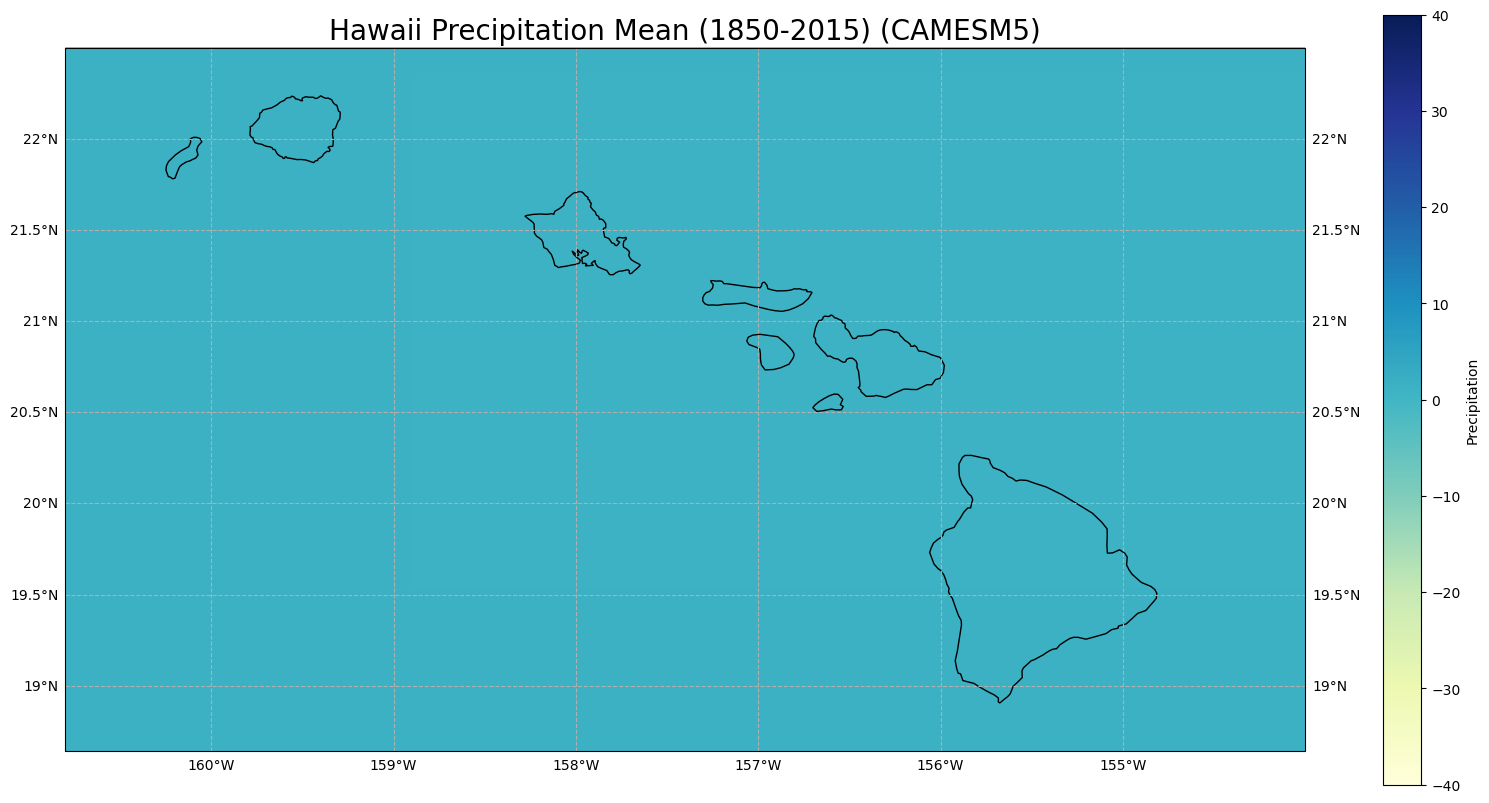

In [37]:
# Map of historical CANESM5

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_hist_avg.lon, 
                     can_hist_avg.lat, 
                     can_hist_avg["pr"], 
                     transform=map, 
                     cmap="YlGnBu", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Hawaii Precipitation Mean (1850-2015) (CAMESM5)", fontsize= 20)
plt.show()

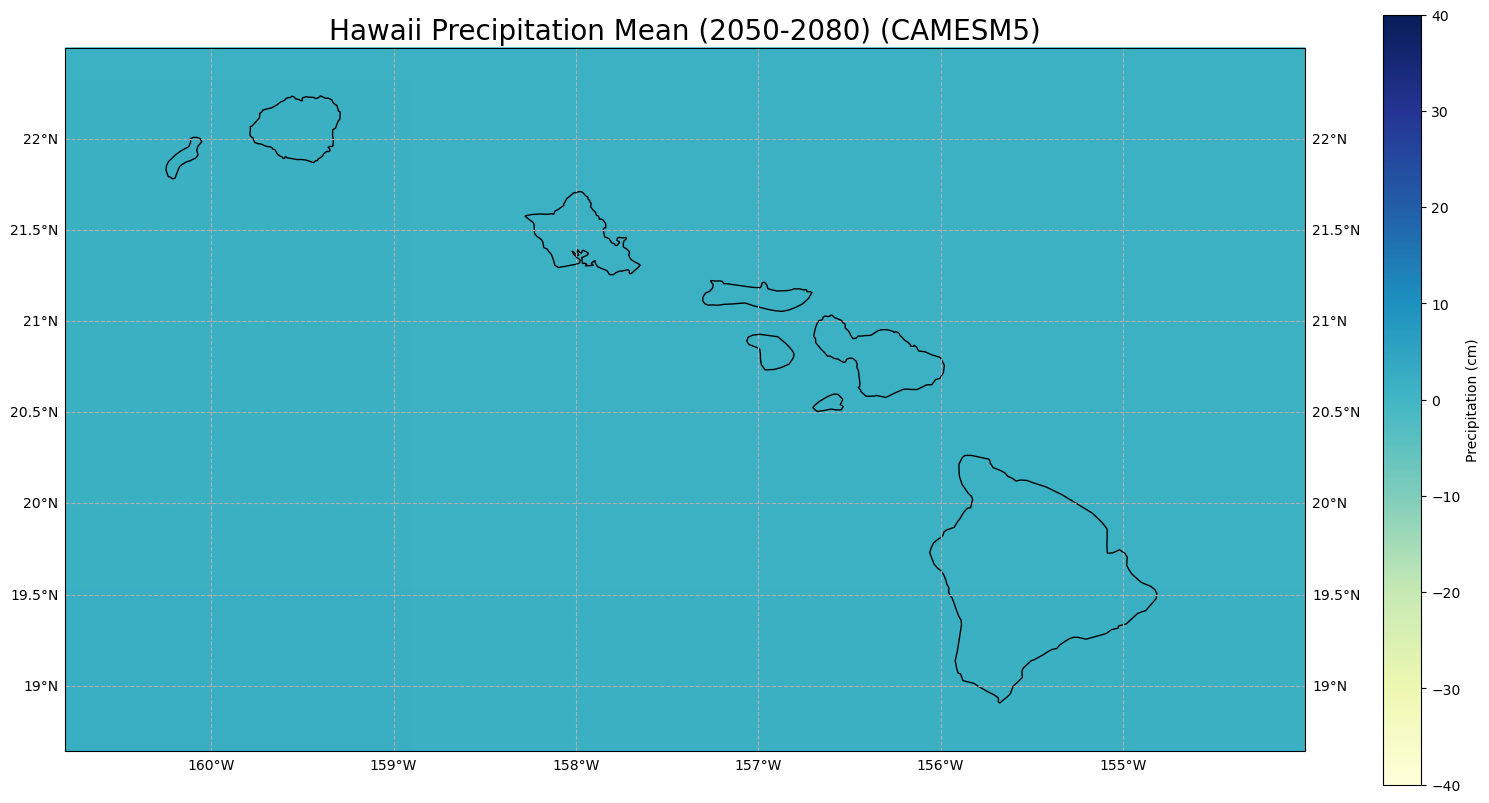

In [38]:
# CANESM5 Future

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_fut_avg.lon, 
                     can_fut_avg.lat,  
                     can_fut_avg["pr"], 
                     transform=map, 
                     cmap="YlGnBu", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation (cm)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Hawaii Precipitation Mean (2050-2080) (CAMESM5)", fontsize= 20)
plt.show()

Overall, precipitation appears to hold fairly constant over time, and the range seems consistent over our entire space. There are many reasons why this could be the case, perhaps due to the small size of our region for example. However, when comparing our results with other projects based in this region, and other assignments conducted in this course (EDS 296), we found that this is likely the case due to the homogeneity of climate factors over the Hawaiian islands (proximity to the equator influencing heat distribution and precipitation patterns).

We took a look at the difference in precipitation between future and historical projections to see what the predicted change will be...

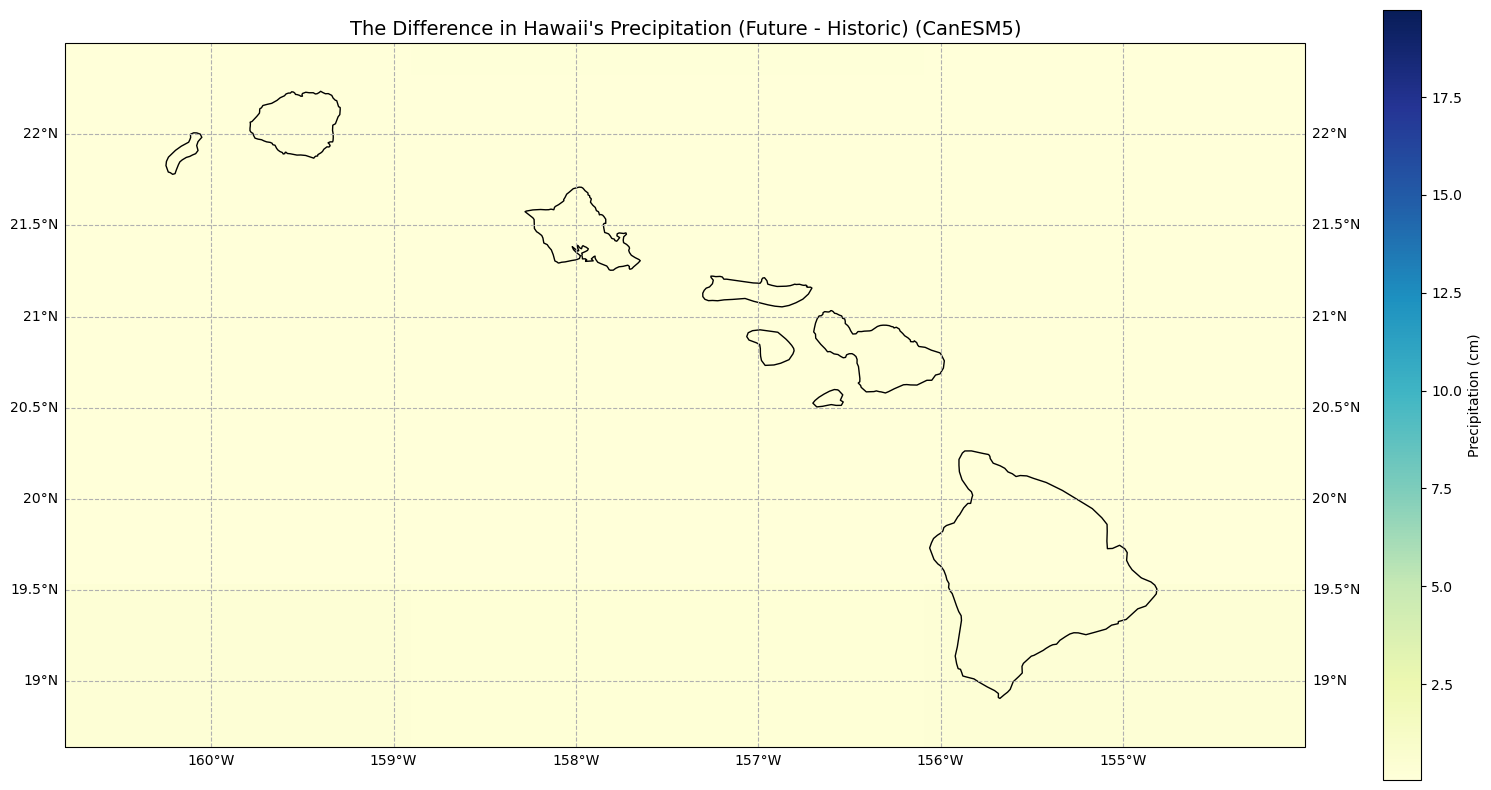

In [41]:
vmin = ces_fut_avg.pr.values.min()
vmax = ces_fut_avg.pr.values.max()


# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(can_fut_avg.lon, 
                     can_fut_avg.lat, 
                     can_fut_avg.pr.values - can_hist_avg.pr.values, 
                     transform=map, cmap="YlGnBu", vmin=vmin, vmax=vmax)

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation (cm)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("The Difference in Hawaii's Precipitation (Future - Historic) (CanESM5)", fontsize= 14)
plt.show()

The predicted difference with the CanESM5 model is an increase of about 2 centimeters overall for the entire region. Again, we are attributing the homogenous results to Hawaii's location, but we would likley get more nuanced results if we took into account other environmental factors.

#### CESM2 Historical & Future

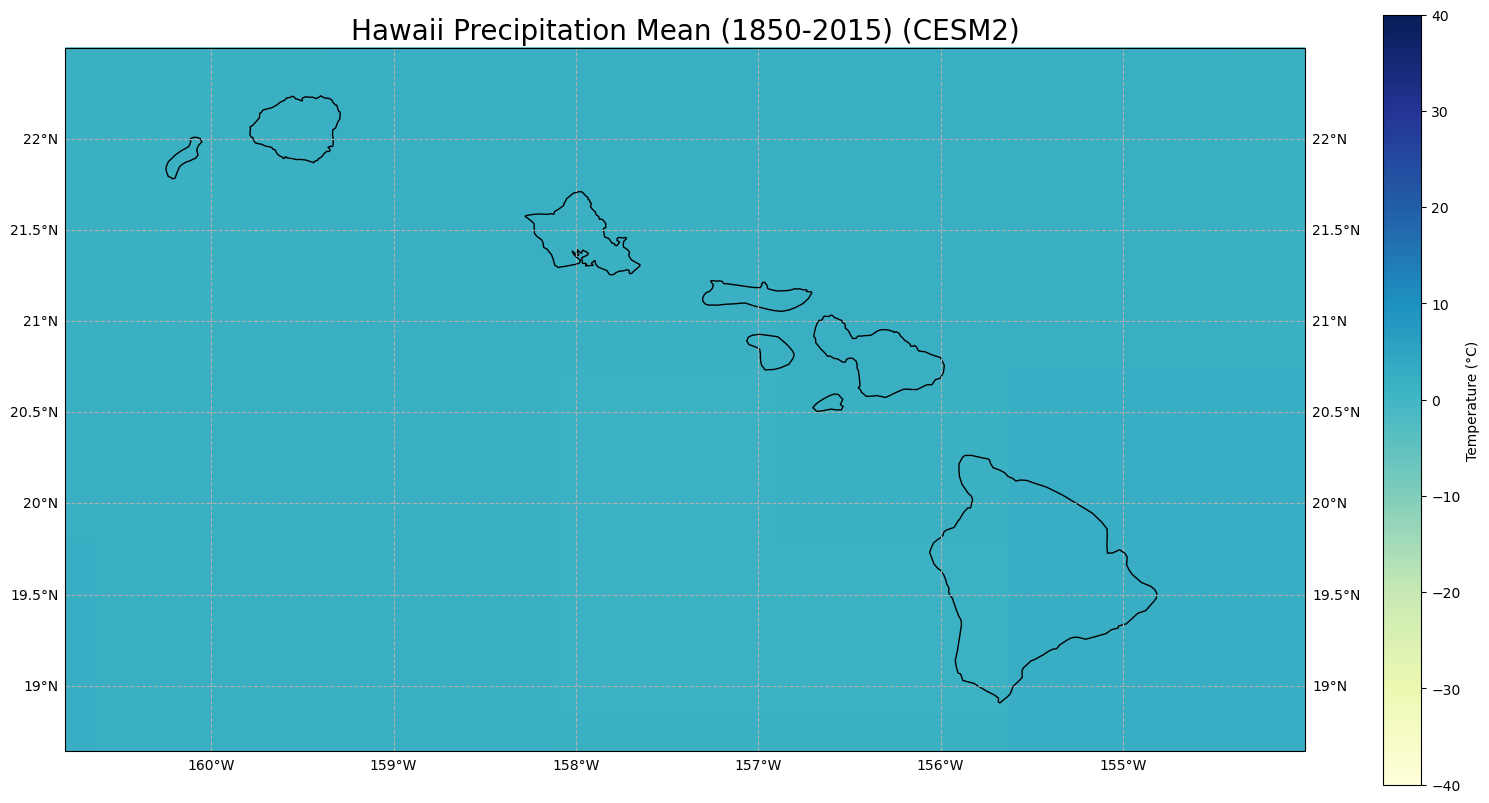

In [40]:
# CESM2 1960-1990

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(ces_hist_avg.lon, 
                     ces_hist_avg.lat, 
                     ces_hist_avg["pr"], 
                     transform=map, 
                     cmap="YlGnBu", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Hawaii Precipitation Mean (1850-2015) (CESM2)", fontsize= 20)
plt.show()

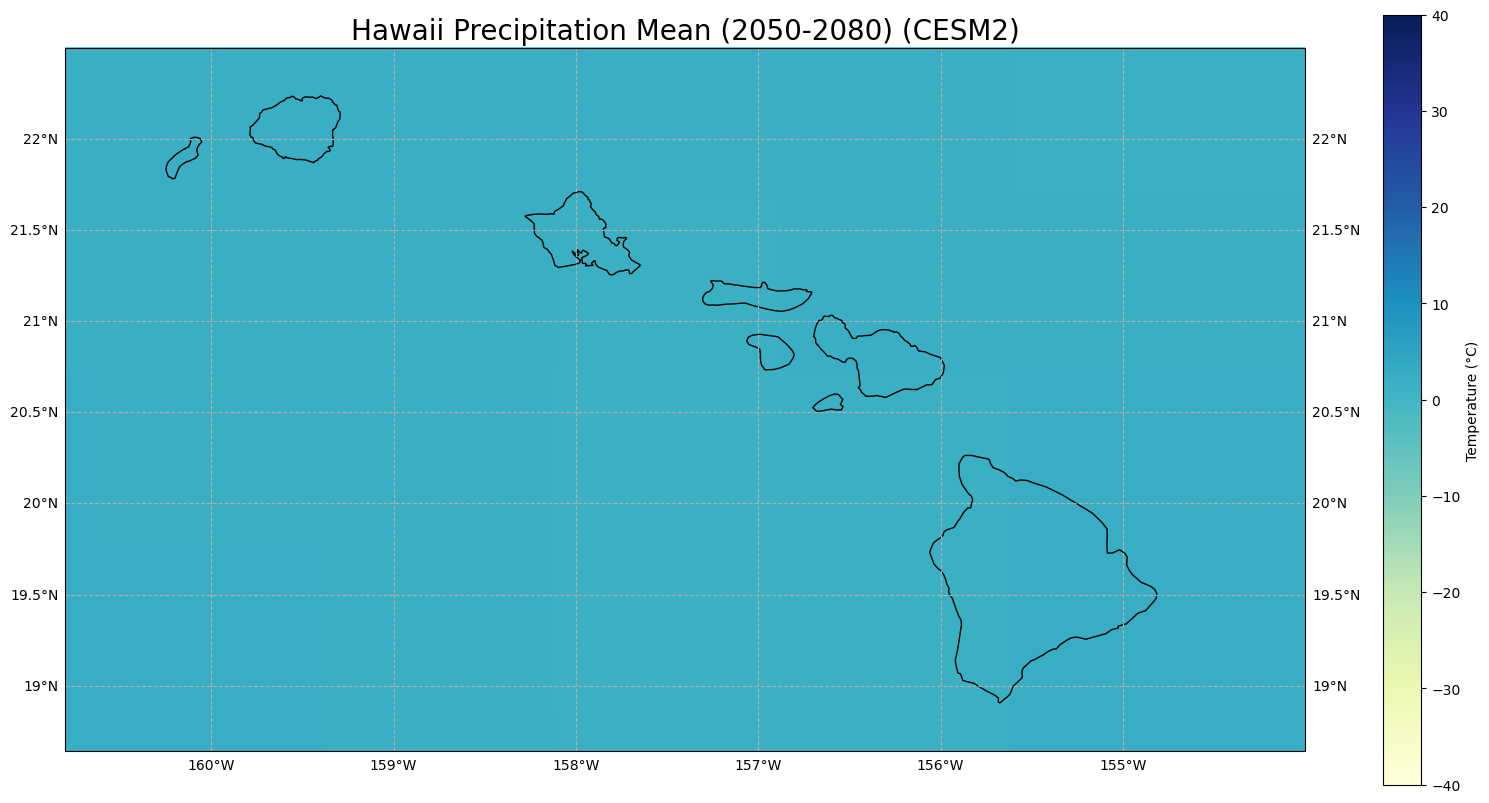

In [42]:
# CESM2 2050-2080

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(ces_fut_avg.lon, 
                     ces_fut_avg.lat, 
                     ces_fut_avg["pr"], 
                     transform=map, 
                     cmap="YlGnBu", 
                     vmin=-40, 
                     vmax=40)

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Temperature (°C)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("Hawaii Precipitation Mean (2050-2080) (CESM2)", fontsize= 20)
plt.show()

Again, we see a very similar trend in the CESM2 models compared to the CanESM5 models. There is a slight increase in expected precipitation here (closer to 10 cm than 5 cm), but not much. We will also check the predicted difference in future and historical projections for the CESM2 models

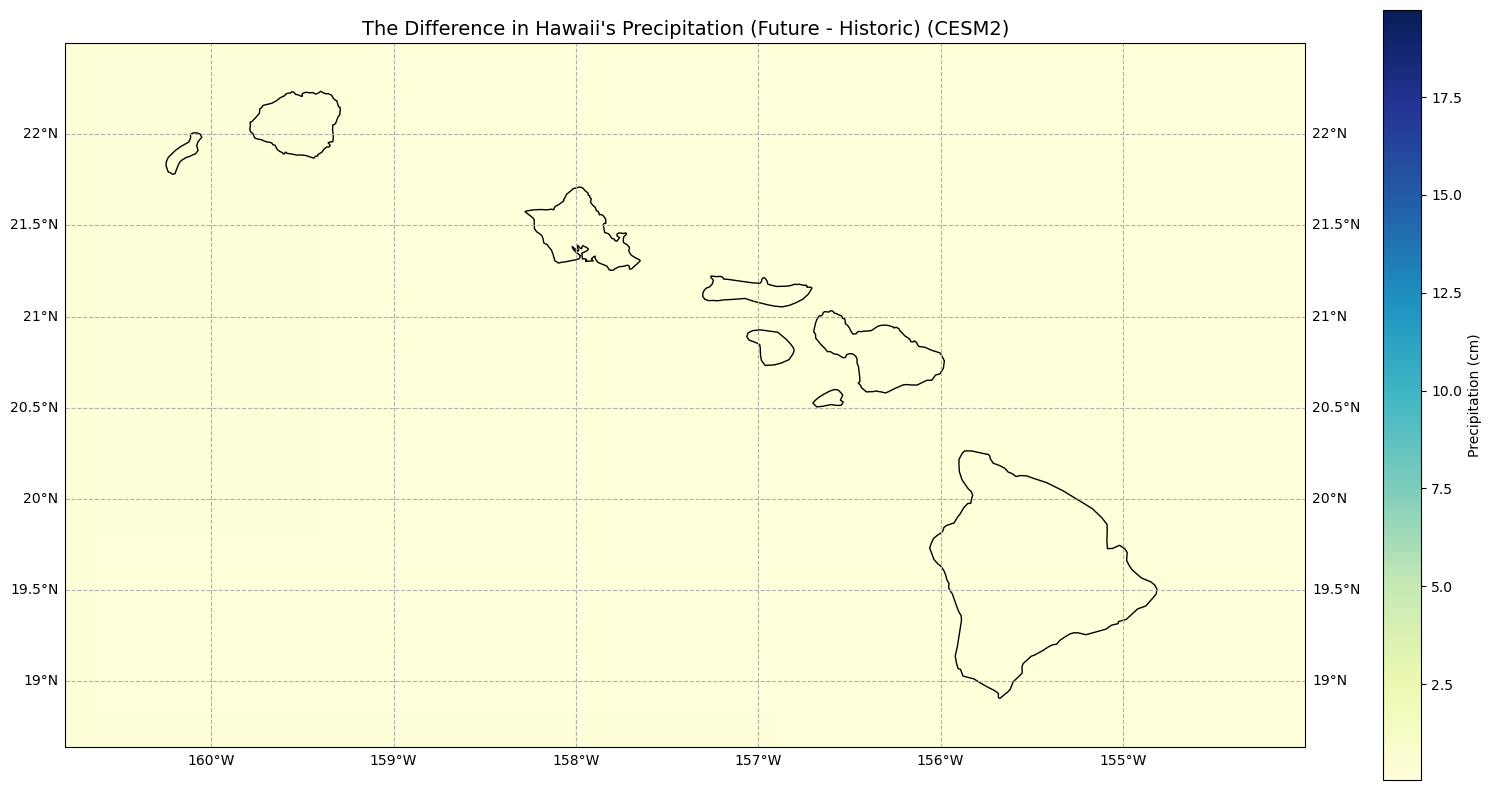

In [43]:
# Now lets look at CESM2...


vmin = ces_fut_avg.pr.values.min()
vmax = ces_fut_avg.pr.values.max()

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})

# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(ces_fut_avg.lon, 
                     ces_fut_avg.lat, 
                     ces_fut_avg.pr.values - ces_hist_avg.pr.values, 
                     transform=map, cmap="YlGnBu", vmin=vmin, vmax=vmax)

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Precipitation (cm)")

# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False

# Add title, show plot
ax.set_title("The Difference in Hawaii's Precipitation (Future - Historic) (CESM2)", fontsize= 14)
plt.show()

Yet again, the precipitation results show now trends between islands or major differences within our region. To get a better visual for how precipitation typically varies over time, we decided to do time plots as well to confirm our results

### Precipitation Time Plots

In [46]:
# Define bounds for Hawaii
lat_min, lat_max = 18.64, 22.5
lon_min, lon_max = -160.8, -154

# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
res_lat = (can_data.lat >= lat_min) & (can_data.lat <= lat_max)
res_lon = (can_data.lon >= lon_min) & (can_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_res = can_data.where(res_lat & res_lon, drop=True)

# Average over lat, lon dimensions to get a time series ... from looking at the output of tos_CI it looks like these are j and i
pr_res = pr_res.mean(dim=["lat", "lon"])

#### CanESM5 Time Plots

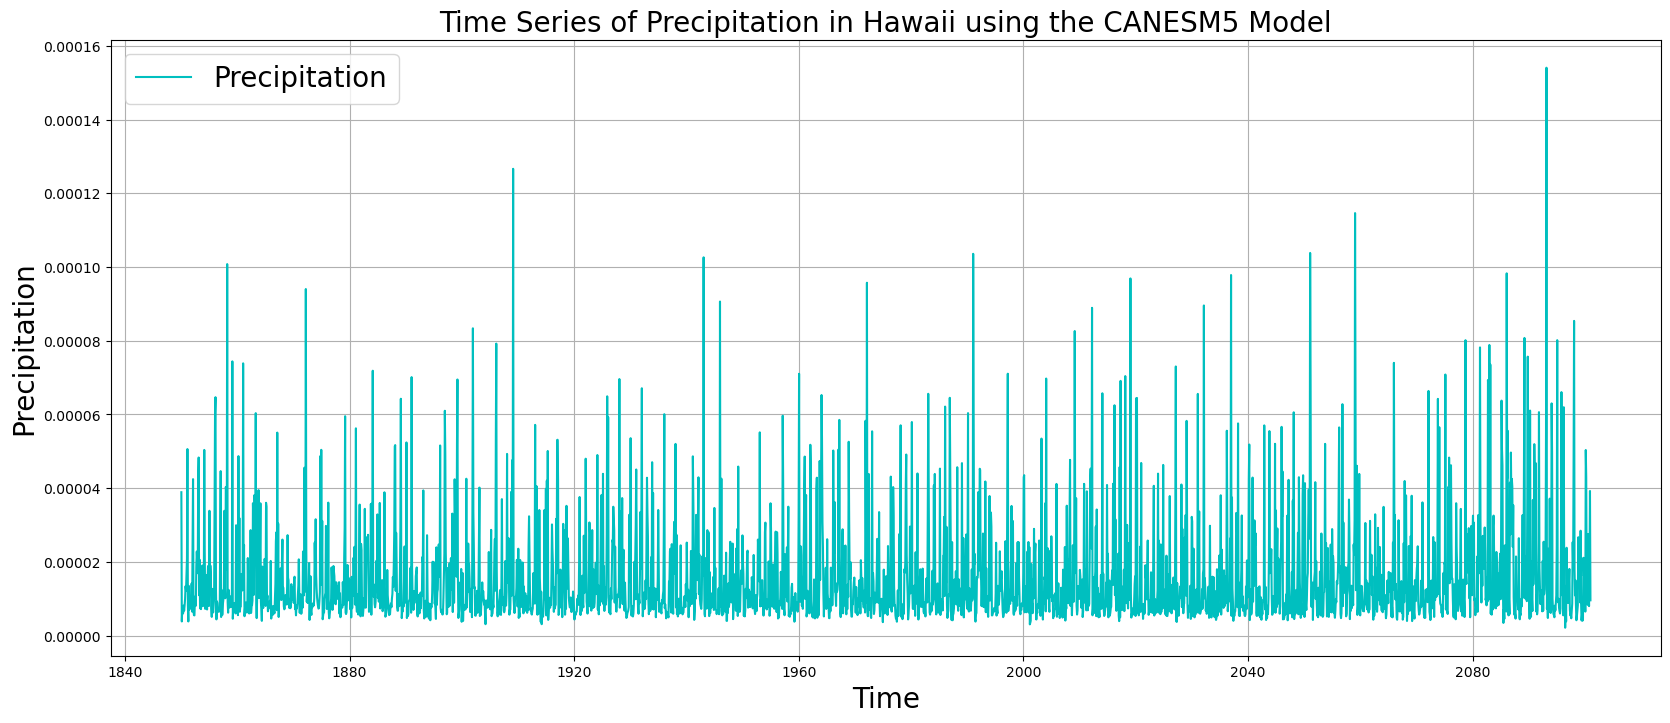

In [47]:
# Convert time to an array
time = pr_res["time"].values

# Lets plot res!
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, pr_res["pr"].values, label='Precipitation', color='c')
ax.set_title("Time Series of Precipitation in Hawaii using the CANESM5 Model", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

#### CESM2 Time Plots

In [49]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
res_lat = (ces_data.lat >= lat_min) & (ces_data.lat <= lat_max)
res_lon = (ces_data.lon >= lon_min) & (ces_data.lon <= lon_max)

# Find points where the mask value is True, drop all other points
pr_res = ces_data.where(res_lat & res_lon, drop=True)

# Average over lat, lon dimensions to get a time series ... from looking at the output of tos_CI it looks like these are j and i
pr_res = pr_res.mean(dim=["lat", "lon"])

# Prepare time variable as an array
time = pr_res["time"].values

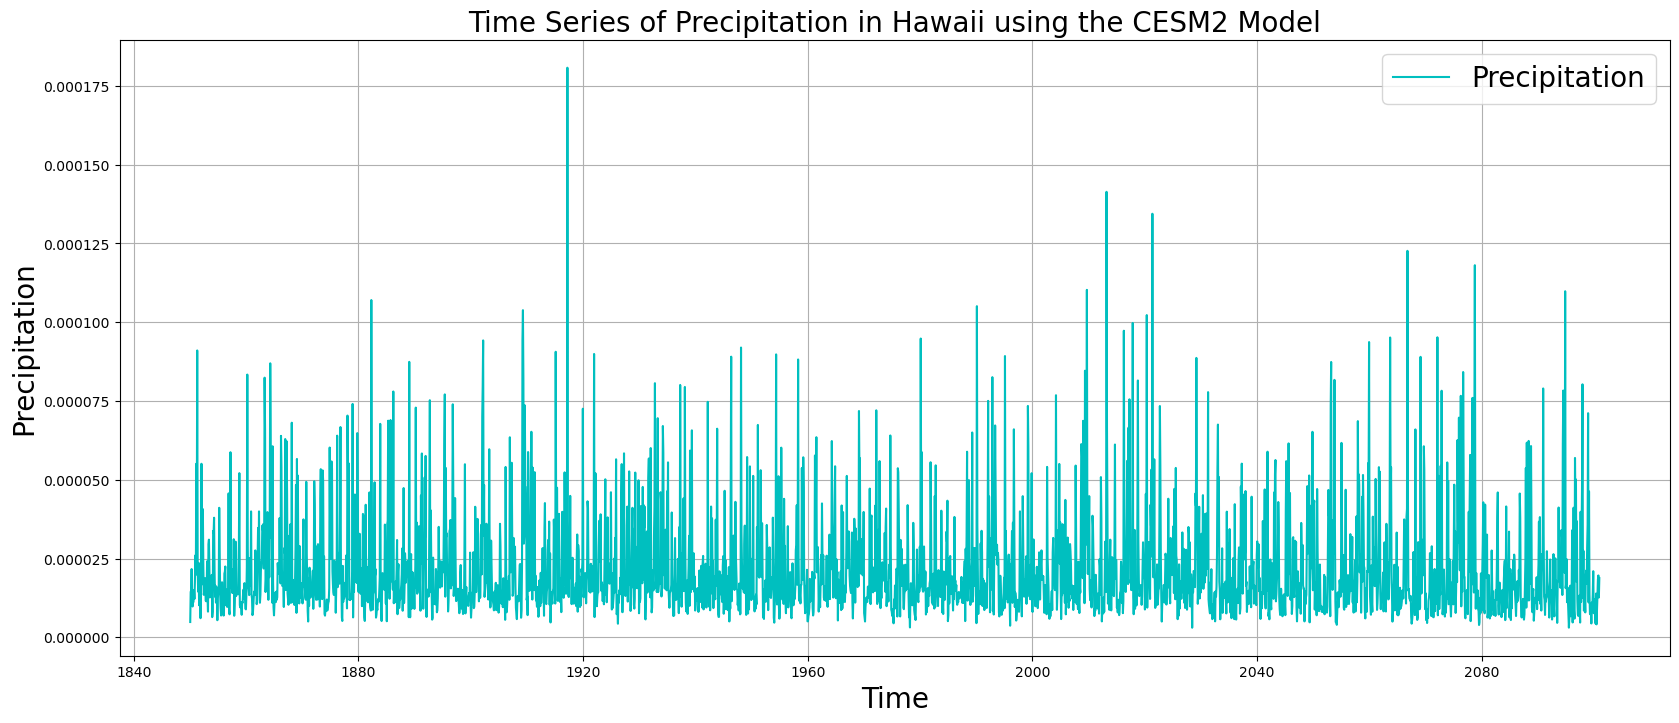

In [50]:
# Lets plot res!
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(time, pr_res["pr"].values, label='Precipitation', color='c')
ax.set_title("Time Series of Precipitation in Hawaii using the CESM2 Model", fontsize=20)
ax.set_xlabel("Time", fontsize=20)
ax.set_ylabel("Precipitation", fontsize=20)
ax.legend(fontsize=20)
ax.grid()
plt.show()

Both the CanESM5 and CESM2 time plots show that precipitation shows slight variablity, but on the whole is fairly stable over the Hawaiian islands.

## Variable 3: Near Surface Shortwave Raditation (rsds)

For this section, we will be mapping ensemble spread and statistical significance of shortwave radiation over the Hawiian Islands, to in more information in regards to land versus sea temperature variation. This is slightly different from the other two analyses, where we looked at ensemble member r10i1p1f1 specifically.

Another difference in this analysis was that CanESM5 and CESM2 many ensemble members (over 30) that fit our criteria, an as a result were too strenuous to run on our devices (utilizing the MEDS workbench server). Instead, we chose ACCESS-CM2, another model that has good coverage of this area, but still had multiple ensemble members to loop over (3 versus 30).

In [53]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [71]:
# Extract data just for ACCESS-CM2
# Specify search terms to query catalog 
source_id = 'ACCESS-CM2'
table_id = 'Amon'
variable_id = 'rsds'

# Extract historical data
res_access_hist = catalog.search(experiment_id='historical', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)
# Extract future SSP projection data
res_access_ssp = catalog.search(experiment_id='ssp370', source_id=source_id, table_id=table_id, 
                                 variable_id=variable_id)

In [72]:
# Make a list of the unique ensemble members
# historical
mems_hist = res_access_hist.df.member_id.unique()
# SSP
mems_ssp = res_access_ssp.df.member_id.unique()

# Convert these to sets, find the intersection between them, and convert back to a list
common_mems = list(set(mems_hist) & set(mems_ssp))

In [73]:
# Loop over the member Ids

# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    hist_mask = res_access_hist.df['member_id'] == common_mems[mem]
    # extract (first) location where the mask is True
    hist_loc = res_access_hist.df['member_id'][hist_mask].index[0]
    
    # Do the same thing for the SSP ensemble
    ssp_mask = res_access_ssp.df['member_id'] == common_mems[mem]
    ssp_loc = res_access_ssp.df['member_id'][ssp_mask].index[0]
    
    # Extract data from each entry as xarray
    temp_data_hist = xr.open_zarr(res_access_hist.df['zstore'][hist_loc], storage_options={'anon': True})
    temp_data_ssp = xr.open_zarr(res_access_ssp.df['zstore'][ssp_loc], storage_options={'anon': True})
    
    # Concatenate the historical and SSP data across the time dimension
    temp_data = xr.concat([temp_data_hist, temp_data_ssp], dim="time")
    
    # Add the concatenated data to a list
    access_data.append(temp_data)

# Concatenate the list into a single xarray object
access_data = xr.concat(access_data, dim="member")

# Store the actual member information as values of the new dimension
access_data = access_data.assign_coords(member=("member", common_mems))

r3i1p1f1
r2i1p1f1
r1i1p1f1


In [69]:
# Check the units of the shortwave radiation variable
access_data.rsds.units

'W m-2'

#### Significance Testing

In [74]:
# Get data for an earlier period: 20th century
data_early = access_data.sel(time=slice("1850-01-01", "1900-12-31"))

# Get data for a later period: 21st century
data_late = access_data.sel(time=slice("2050-01-01", "2100-12-31"))

In [58]:
# Take the time average
data_early_mn = data_early.mean(dim="time")
data_late_mn = data_late.mean(dim="time")

In [60]:
# Extract the values into Numpy arrays
rsds_early = data_early_mn.rsds.values
rsds_late = data_late_mn.rsds.values

In [61]:
# Define empty output arrays
# T-test
rsds_pvals_t = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))
# Rank-sum test
rsds_pvals_rs = np.empty((len(data_early_mn.lat), len(data_early_mn.lon)))

# Loop over lat, lon in the Numpy array
for latidx in range(len(data_early_mn.lat)):
    for lonidx in range(len(data_early_mn.lon)):
        # Run test on each grid point
        # T-test
        ttest = stats.ttest_ind(rsds_early[:,latidx, lonidx], rsds_late[:, latidx, lonidx])
        # Rank-sum
        stat_rs, pval_rs = stats.ranksums(rsds_early[:,latidx, lonidx], rsds_late[:, latidx, lonidx])
        
        # Save results in the output array
        rsds_pvals_rs[latidx, lonidx] = pval_rs
        rsds_pvals_t[latidx, lonidx] = ttest.pvalue

/tmp/ipykernel_67328/3974449383.py:12: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(rsds_early[:,latidx, lonidx], rsds_late[:, latidx, lonidx])


In [62]:
# Define region in one variable instead (lon, lat)
hawaii = [-160.8, -154.0, 18.64, 22.5]

#### Map Epoch Differences with Significance Values

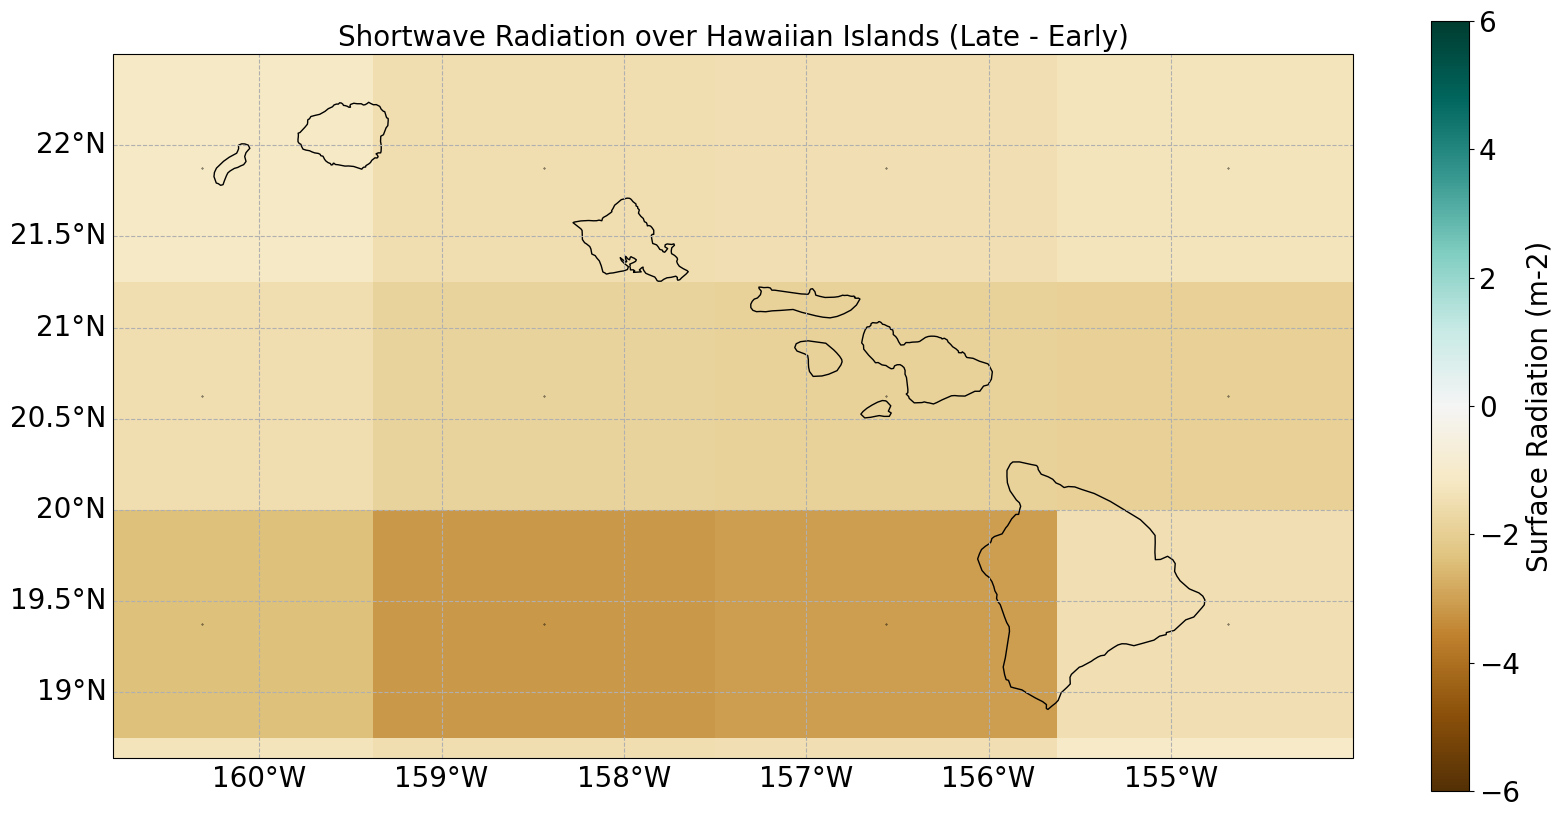

In [ ]:
# Calculate ensemble-mean epoch difference
ensmn_rsdsdiff = rsds_late.mean(axis=0) - rsds_early.mean(axis=0)

# Define object containing PlateCarree projection
map = ccrs.PlateCarree()

# Create figure/axis objects, use the map object to specify associated projection
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": map})
# Plot temperature data on the axes using the coolwarm colormap
plot = ax.pcolormesh(data_early_mn.lon, data_early_mn.lat, ensmn_rsdsdiff, 
                     transform=map, cmap="BrBG", vmin=-6, vmax=6)

# Add colorbar and label it
cbar = plt.colorbar(plot, ax=ax)
cbar.set_label("Surface Radiation (m-2)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
# Add coastline/border lines
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")
# Add grid lines
gl = ax.gridlines(draw_labels=True, linestyle="--") 
gl.top_labels = False
gl.right_labels = False

# Set font size for x, y-axis labels
gl.xlabel_style = {'size': 20}
gl.ylabel_style = {'size': 20}


# Statistical significance for historical vs future precip change regressed on gradient change
latitudes, longitudes = np.where(rsds_pvals_rs < 0.05)
lats = data_early_mn.coords['lat'][latitudes].values
lons = data_early_mn.coords['lon'][longitudes].values
ax.scatter(lons, lats, color='black', s=0.1, transform=ccrs.PlateCarree())

# Set spatial extent of plot
ax.set_extent(hawaii, crs=ccrs.PlateCarree())

# Add title, show plot
ax.set_title("Shortwave Radiation over Hawaiian Islands (Late - Early)", fontsize= 20)
plt.show()

We see from the shortwave radiation map that radiation is expected to decrease in a large block that contains the western half of the Big Island (Hawaii), but decrease only slightly over most of the region, with the least change occuring over the islands Kaua'i and Ni'hau. 

After comparing this result with the sea surface temperature (tos) information for the Hawaiian islands by another EDS 296 project, we determined that tos is expected to increase in this exact same pattern (with a large block in the south west corner). We came to the conclusion that increased temperature in this area would lead to increased evaporation, and thereby increased cloud cover, which would decrease radiation in turn.

## Final Takeaways

Near surface temperature (tas) is predicted to increase slightly over the Hawaiian islands, as well as precipitation (pr), while near surface shortwave radiation (rsds) decreases. In terms of pollution, this could indicate that increased temperatures and increased runoff load will lead to increased algal proliferation if more work is not done to curtail nutrient pollution in the future. 

Noting the interesting radiation patterns over the Big Island, we have reason to be slighlty concerned about the Big Island's reefs specifically. Increased ocean surface temperatures (tos) can stress corals and lead to bleaching events, especially combined with increased pollution from island runoff. However, shortwave radiation includes UV light and other wavelengths that are beneficial to photosynthetic production by coral symbionts. With decreased photosynthetic capability, corals are much more likely to die off under stress, and the western side of the Big Island holds most of its reefs. If we were to make recommendations from this project, it would be to promote the research and protection of the island of Hawaii's western reefs.